# K-means-clustering for music genre prediction

## Imports

In [1]:
%matplotlib inline

import ast
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import MeanShift, KMeans, AffinityPropagation, AgglomerativeClustering, FeatureAgglomeration, SpectralClustering, estimate_bandwidth
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, v_measure_score
#from sklearn import cluster

In [2]:
tracks = pd.read_csv("/Users/andrescarvajal/Desktop/Data Science/music_genre.csv")


In [3]:
tracks.duplicated().any() # duplicated() returns a bool if the entry is duplicated, any() method returns true if find any true over the iterable object.


True

In [4]:
duplicated = tracks.duplicated() #Storing duplicated entries, will be a Series Object 
print(duplicated)

0        False
1        False
2        False
3        False
4        False
         ...  
50000    False
50001    False
50002    False
50003    False
50004    False
Length: 50005, dtype: bool


In [5]:
tracks.drop([10000, 10001, 10002, 10003, 10004], inplace = True)

In [6]:
tracks.drop([ 'duration_ms','track_name','instance_id'], axis=1, inplace=True)

In [7]:
audio_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
tracks.head()

,artist_name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,Röyksopp,27.0,0.00468,0.652,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,Thievery Corporation,31.0,0.01270,0.622,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,Dillon Francis,28.0,0.00306,0.620,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,Dubloadz,34.0,0.02540,0.774,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,What So Not,32.0,0.00465,0.638,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [8]:
#Remove all entries with "?"
tracks = tracks.drop(tracks[tracks["tempo"] == "?"].index)
tracks["tempo"] = tracks["tempo"].astype("float")

array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>]],
      dtype=object)

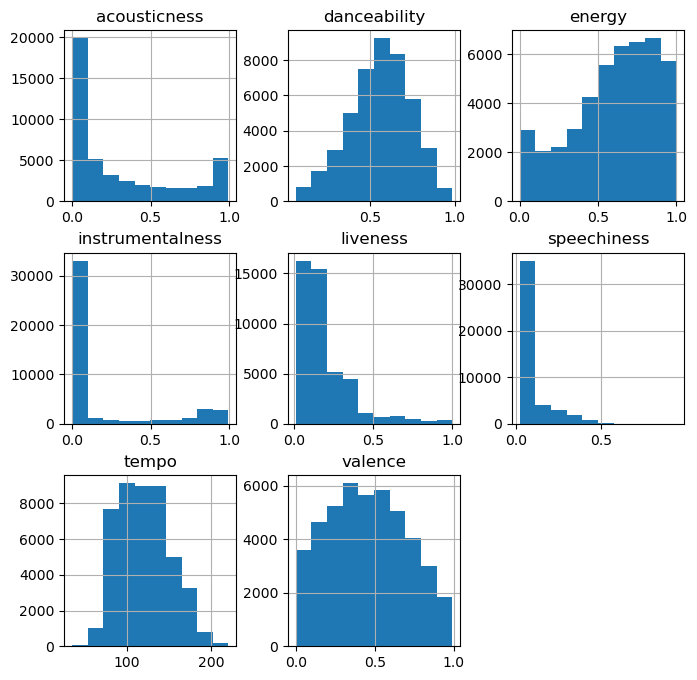

In [9]:
X_prenorm = tracks[audio_cols]
pd.DataFrame(X_prenorm,columns=audio_cols).hist(figsize=(8,8))

In [10]:
genre_count = tracks.groupby('music_genre').agg({'music_genre':'count'})['music_genre']
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values
print(genre_count)
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

music_genre
Alternative    4495
Anime          4497
Blues          4470
Classical      4500
Country        4486
Electronic     4466
Hip-Hop        4520
Jazz           4521
Rap            4504
Rock           4561
Name: music_genre, dtype: int64
Major genres: ['Alternative' 'Anime' 'Blues' 'Classical' 'Country' 'Electronic'
 'Hip-Hop' 'Jazz' 'Rap' 'Rock'] 
Minor Genres: []


In [11]:
### method: Merge nearest genres
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values

# Scale Tempo
tempo = tracks['tempo'].values.reshape(-1,1)
tracks['tempo'] = MinMaxScaler().fit_transform(tempo)

# Normalize audio columns
norm = Normalizer()
tracks[audio_cols] = norm.fit_transform(tracks[audio_cols])

# Group By Mean
genre_groupby = tracks.groupby('music_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'music_genre':'cluster'}, axis=1)
#clusters['method'] = 'Mean'

minor_clusters = clusters.loc[clusters.cluster.isin(minor_genres)]
major_clusters =  clusters.loc[clusters.cluster.isin(major_genres)]

new_genres = dict(zip(major_genres,major_genres))

for i, r in minor_clusters.iterrows():
    genre = r[0]
    genre_coordinates = r[1:9].values
    genre_coordinates_other = major_clusters[audio_cols].values

    # Calculate distances between each genre; choose closest genre as the one with minimum distance
    distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
    min_distance = min(distances)
    closest_genre = major_genres[distances.index(min_distance)]
    print("minor genre: {}, closest major genre: {}".format(genre, closest_genre))

    # Reassign genre values for largely minority genres
    tracks['music_genre'].loc[tracks['music_genre']==genre] = closest_genre
    new_genres[closest_genre] = new_genres[closest_genre] + "/" + genre

tracks = tracks.replace(new_genres)
print(tracks.groupby('music_genre').agg({'music_genre':'count'})['music_genre'])

music_genre
Alternative    4495
Anime          4497
Blues          4470
Classical      4500
Country        4486
Electronic     4466
Hip-Hop        4520
Jazz           4521
Rap            4504
Rock           4561
Name: music_genre, dtype: int64


In [12]:
genre_groupby = tracks.groupby('music_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'music_genre':'cluster'}, axis=1)
clusters['method'] = 'Mean'

clusters

,cluster,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,method
0,Alternative,50.239822,0.138950,0.443236,0.574990,0.045966,0.157707,-6.545273,0.071280,0.384965,0.352825,Mean
1,Anime,24.279297,0.216846,0.356011,0.503453,0.198535,0.146461,-7.934473,0.048494,0.372913,0.320732,Mean
2,Blues,34.840940,0.243795,0.413244,0.474746,0.068303,0.175637,-8.980206,0.047506,0.364501,0.440608,Mean
3,Classical,29.255333,0.655640,0.228750,0.135387,0.429211,0.122350,-21.604702,0.039038,0.281134,0.152424,Mean
4,Country,46.020285,0.222589,0.468955,0.510074,0.004227,0.147076,-7.306072,0.038976,0.386584,0.418629,Mean
5,Electronic,38.182938,0.093316,0.462851,0.549858,0.245570,0.154015,-7.070008,0.073316,0.368006,0.281887,Mean
6,Hip-Hop,58.382080,0.138275,0.562821,0.502085,0.008103,0.155456,-6.848804,0.160376,0.359968,0.359267,Mean
7,Jazz,40.881885,0.373542,0.436871,0.352083,0.246187,0.128372,-11.185422,0.054752,0.310669,0.370456,Mean
8,Rap,60.548179,0.134824,0.555261,0.515228,0.007070,0.154588,-6.676231,0.146155,0.367029,0.350159,Mean
9,Rock,59.622890,0.157901,0.436446,0.552672,0.041422,0.148316,-7.221685,0.042800,0.383021,0.407416,Mean


array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>]],
      dtype=object)

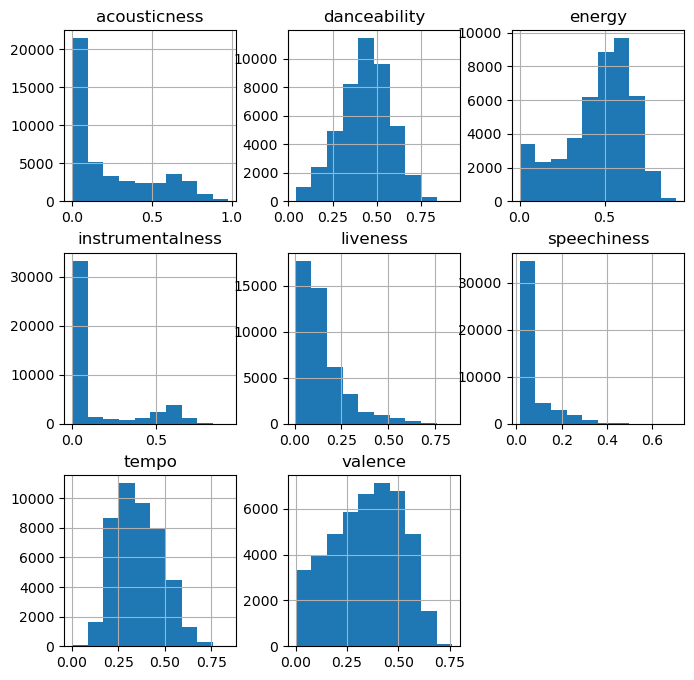

In [13]:
tracks[audio_cols].hist(figsize=(8,8))

### Clustering on all genres: Preliminary Machine Learning

In [14]:
clusters

,cluster,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,method
0,Alternative,50.239822,0.138950,0.443236,0.574990,0.045966,0.157707,-6.545273,0.071280,0.384965,0.352825,Mean
1,Anime,24.279297,0.216846,0.356011,0.503453,0.198535,0.146461,-7.934473,0.048494,0.372913,0.320732,Mean
2,Blues,34.840940,0.243795,0.413244,0.474746,0.068303,0.175637,-8.980206,0.047506,0.364501,0.440608,Mean
3,Classical,29.255333,0.655640,0.228750,0.135387,0.429211,0.122350,-21.604702,0.039038,0.281134,0.152424,Mean
4,Country,46.020285,0.222589,0.468955,0.510074,0.004227,0.147076,-7.306072,0.038976,0.386584,0.418629,Mean
5,Electronic,38.182938,0.093316,0.462851,0.549858,0.245570,0.154015,-7.070008,0.073316,0.368006,0.281887,Mean
6,Hip-Hop,58.382080,0.138275,0.562821,0.502085,0.008103,0.155456,-6.848804,0.160376,0.359968,0.359267,Mean
7,Jazz,40.881885,0.373542,0.436871,0.352083,0.246187,0.128372,-11.185422,0.054752,0.310669,0.370456,Mean
8,Rap,60.548179,0.134824,0.555261,0.515228,0.007070,0.154588,-6.676231,0.146155,0.367029,0.350159,Mean
9,Rock,59.622890,0.157901,0.436446,0.552672,0.041422,0.148316,-7.221685,0.042800,0.383021,0.407416,Mean


### Finding appropriate K-Values


## Elbow Method

Text(0.5, 1.0, 'Elbow Method')

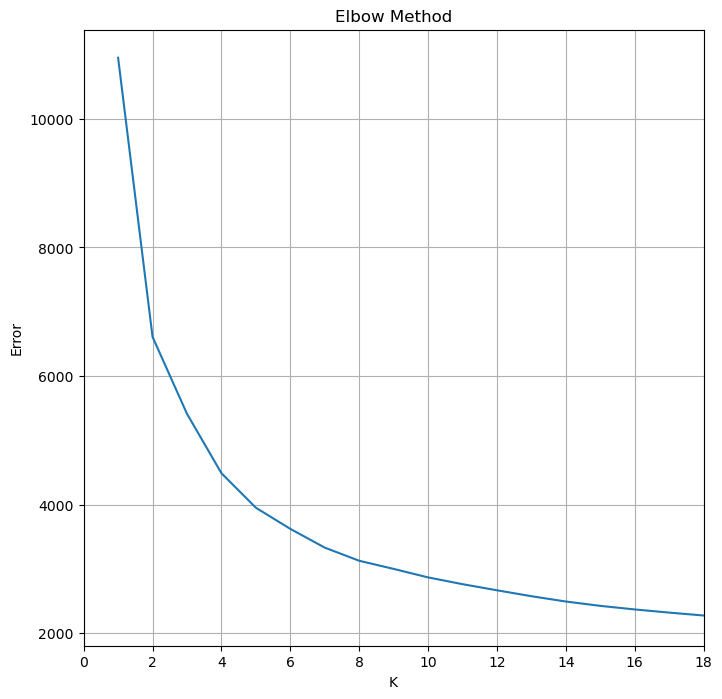

In [15]:
X = tracks[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']]

Ks = np.arange(1, 20)
km = [KMeans(n_clusters=i, random_state=1986) for i in Ks]
score = [-km[i].fit(X).score(X) for i in range(len(km))]
Ks.dtype = int
plt.figure(figsize=(8,8))
plt.plot(Ks,score)
plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Elbow Method')

In [16]:
X = tracks[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']]

km = KMeans(n_clusters=len(major_genres), n_init=10, random_state=1986)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
clusters = pd.concat([clusters, km_clusters])
cols = ['cluster'] + audio_cols + ['method']
clusters = clusters[cols]

In [17]:
clusters

,cluster,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,method
0,Alternative,0.138950,0.443236,0.574990,0.045966,0.157707,0.071280,0.384965,0.352825,Mean
1,Anime,0.216846,0.356011,0.503453,0.198535,0.146461,0.048494,0.372913,0.320732,Mean
2,Blues,0.243795,0.413244,0.474746,0.068303,0.175637,0.047506,0.364501,0.440608,Mean
3,Classical,0.655640,0.228750,0.135387,0.429211,0.122350,0.039038,0.281134,0.152424,Mean
4,Country,0.222589,0.468955,0.510074,0.004227,0.147076,0.038976,0.386584,0.418629,Mean
5,Electronic,0.093316,0.462851,0.549858,0.245570,0.154015,0.073316,0.368006,0.281887,Mean
6,Hip-Hop,0.138275,0.562821,0.502085,0.008103,0.155456,0.160376,0.359968,0.359267,Mean
7,Jazz,0.373542,0.436871,0.352083,0.246187,0.128372,0.054752,0.310669,0.370456,Mean
8,Rap,0.134824,0.555261,0.515228,0.007070,0.154588,0.146155,0.367029,0.350159,Mean
9,Rock,0.157901,0.436446,0.552672,0.041422,0.148316,0.042800,0.383021,0.407416,Mean


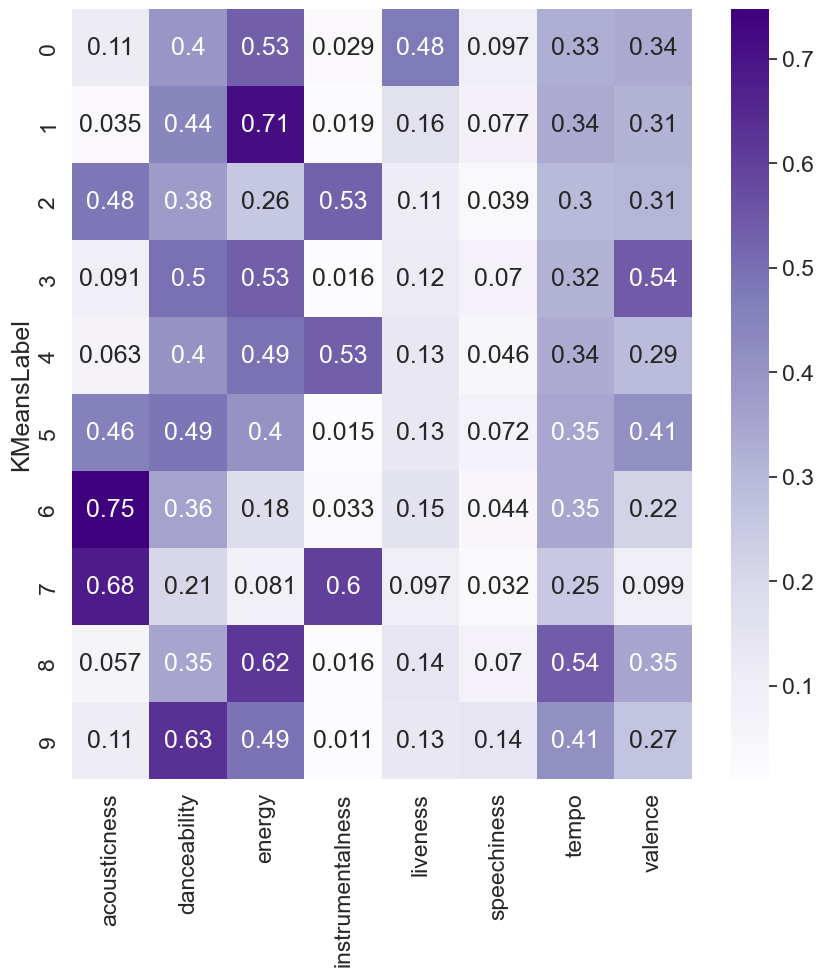

In [18]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(
    data=clusters.loc[clusters.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=True
)
plt.ylabel("KMeansLabel")
plt.savefig('heatmap_all.png')

* KM0: ?
* KM1: ?
* KM2: ?
* KM3: ?
* KM4: ? 
* KM5: ?
* KM6: ?
* KM7: ?
* KM8: ?
* KM9: ?

Based on this matrix I'm gonnna drop some columns from the dataframe to get a best fit.

In [19]:

### Assign K-Means Label to Descriptive Labels
descriptive_labels = ["KM0", "KM1", "KM2", 
                     "KM3", "KM4", "KM5",
                     "KM6", "KM7", "KM8","KM9"]
unique_labels = np.unique(labels)
translated_labels = dict(zip(unique_labels, descriptive_labels))
tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], labels))

genre_count = tracks.groupby('music_genre').agg({'music_genre':'count'})['music_genre']

# How many instances of each k-means cluster are there?
print("### Instances of KMeans Cluster ###")
print(tracks[['music_genre', 'KMeansLabel']].groupby('KMeansLabel').agg('count'))

# Which cluster corresponds to the most instances per genre?
print("### Which cluster corresponds to the most instances per genre? ###")
print(tracks[['music_genre', 'KMeansLabel']].groupby('music_genre').agg(lambda x:x.value_counts().index[0]))

# Which genre corresponds to the most instances per cluster?
print("### Which genre corresponds to the most instances per cluster? ###")
print(tracks[['music_genre', 'KMeansLabel']].groupby('KMeansLabel').agg(lambda x:x.value_counts().index[0]))

### Instances of KMeans Cluster ###
             music_genre
KMeansLabel             
KM0                 2229
KM1                 5426
KM2                 1897
KM3                 8890
KM4                 3740
KM5                 5628
KM6                 3166
KM7                 3670
KM8                 5266
KM9                 5108
### Which cluster corresponds to the most instances per genre? ###
            KMeansLabel
music_genre            
Alternative         KM1
Anime               KM8
Blues               KM3
Classical           KM7
Country             KM3
Electronic          KM4
Hip-Hop             KM9
Jazz                KM5
Rap                 KM9
Rock                KM3
### Which genre corresponds to the most instances per cluster? ###
             music_genre
KMeansLabel             
KM0                Blues
KM1          Alternative
KM2                 Jazz
KM3              Country
KM4           Electronic
KM5                Blues
KM6            Classical
KM7            Cl

### Evaluating K-Means Visually
X has n_features = n_dimensions = 9, the clustering model can't be plotted as is. Before plugging everything into seaborn, we perform PCA through FeatureAgglomeration in order to reduce the dimensions from 9 to 2. This process effectively takes related features and merges them into different axes.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
tracks['x'] = x
tracks['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [21]:
audio_components = dict(list(zip(audio_cols, zip(*np.round(components,2)))))
audio_components

{'acousticness': (0.67, -0.51),
 'danceability': (-0.19, -0.21),
 'energy': (-0.5, 0.2),
 'instrumentalness': (0.44, 0.77),
 'liveness': (-0.05, -0.0),
 'speechiness': (-0.05, -0.04),
 'tempo': (-0.1, 0.0),
 'valence': (-0.24, -0.24)}

In [22]:
components

array([[ 6.66680359e-01, -1.93528476e-01, -5.03345518e-01,
         4.37713965e-01, -4.60407420e-02, -4.82496475e-02,
        -1.02460899e-01, -2.41221451e-01],
       [-5.10488974e-01, -2.06757161e-01,  1.96272534e-01,
         7.72539857e-01, -2.66594140e-03, -3.87211322e-02,
         2.05133421e-04, -2.44551160e-01]])

In [23]:
singular_values

array([75.00716187, 44.10837466])

/Users/andrescarvajal/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Clustering by Genre, Reduced Dimension')

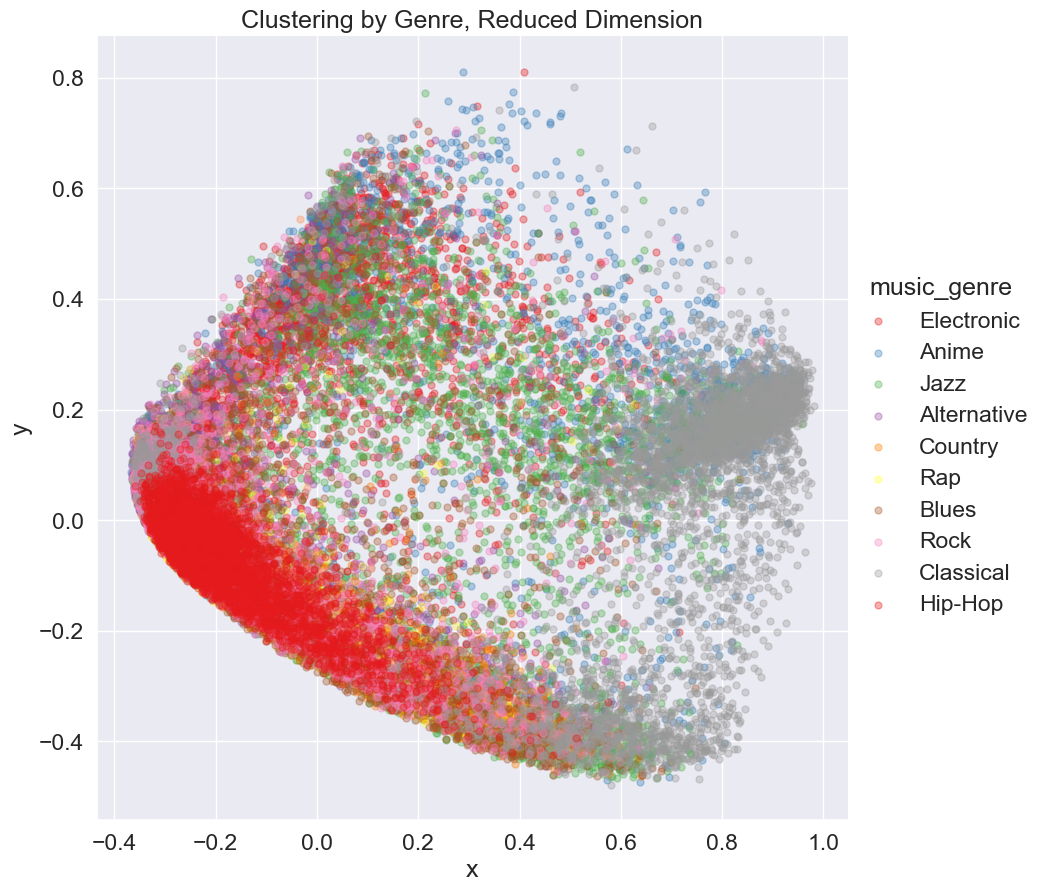

In [24]:
sns.set(font_scale=1.5)
sns.lmplot(data=tracks, x='x', y='y', hue='music_genre', fit_reg=False, legend=True, size=9, palette='Set1',scatter_kws={'alpha':0.35, 's':25})

plt.savefig('pca_scatter_genres.png')
plt.title("Clustering by Genre, Reduced Dimension")

/Users/andrescarvajal/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


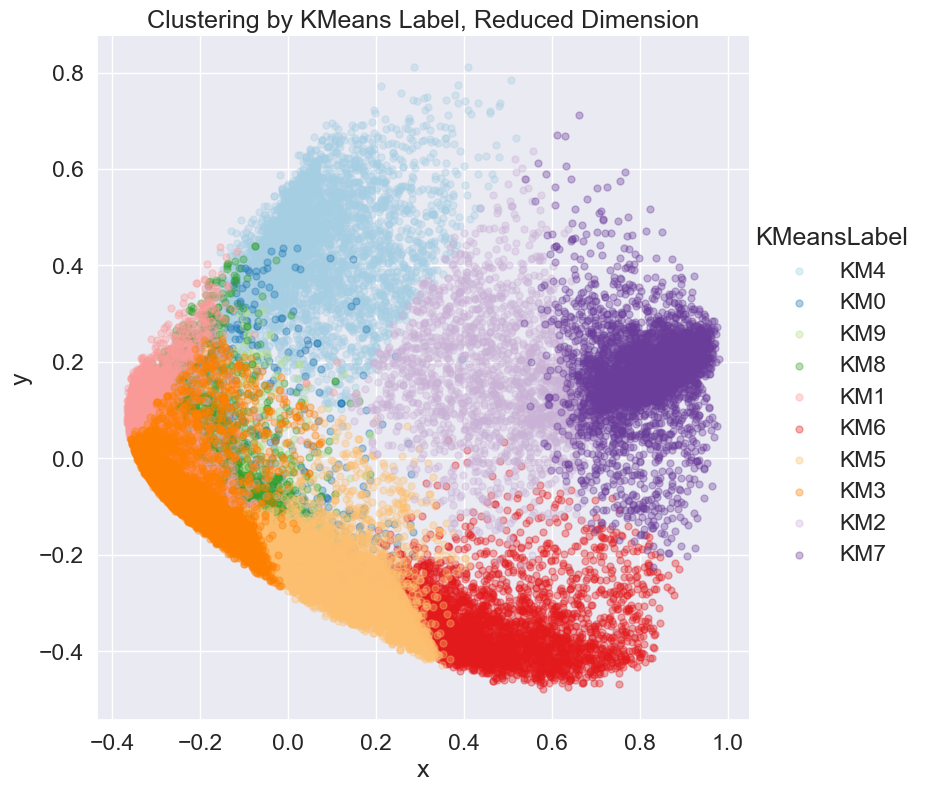

In [25]:
sns.set(font_scale=1.5)

sns.lmplot(data=tracks, x='x', y='y', hue='KMeansLabel', fit_reg=False, legend=True, size=8, palette='Paired',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")

plt.savefig('pca_scatter_KM.png')

In [26]:
tracks.head()

,artist_name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
0,Röyksopp,27.0,0.002869,0.399702,0.576871,0.485528,A#,0.070500,-5.201,Minor,0.045855,0.219401,4-Apr,0.465298,Electronic,KM4,-0.058550,0.396077
1,Thievery Corporation,31.0,0.007925,0.388139,0.555376,0.592818,D,0.077378,-7.043,Minor,0.018721,0.270696,4-Apr,0.331354,Electronic,KM4,0.032886,0.508352
2,Dillon Francis,28.0,0.002415,0.489314,0.595858,0.009313,G#,0.421441,-4.617,Major,0.027228,0.397505,4-Apr,0.262809,Electronic,KM0,-0.278861,0.062953
3,Dubloadz,34.0,0.020752,0.632350,0.571893,0.002067,C#,0.128267,-4.498,Major,0.195261,0.411582,4-Apr,0.220587,Electronic,KM9,-0.271294,0.018321
4,What So Not,32.0,0.003237,0.444191,0.408683,0.632867,F#,0.109307,-6.266,Major,0.028754,0.414482,4-Apr,0.224880,Electronic,KM4,0.119279,0.526898


### There are some genres that could be merged, I'gonna join Rap and Hip-hop, Rock with Country and Jazz with Blues.

In [27]:
for i in range(len(tracks)):
    if tracks.iloc[i]['music_genre'] == "Hip-Hop":
        tracks.iat[i,14] = "Rap"
    elif tracks.iloc[i]['music_genre'] == "Country":
        tracks.iat[i,14] = "Rock"
    elif tracks.iloc[i]['music_genre'] == "Blues":
        tracks.iat[i,14] = "Jazz"
    else:
        continue

In [28]:
tracks["music_genre"].unique()

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Rock', 'Rap',
       'Classical'], dtype=object)

In [29]:
tracks.drop("speechiness", axis = 1, inplace = True)
tracks.drop("instrumentalness", axis = 1, inplace = True)
tracks.drop("liveness", axis = 1, inplace = True)

In [30]:
tracks

,artist_name,popularity,acousticness,danceability,energy,key,loudness,mode,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
0,Röyksopp,27.0,0.002869,0.399702,0.576871,A#,-5.201,Minor,0.219401,4-Apr,0.465298,Electronic,KM4,-0.058550,0.396077
1,Thievery Corporation,31.0,0.007925,0.388139,0.555376,D,-7.043,Minor,0.270696,4-Apr,0.331354,Electronic,KM4,0.032886,0.508352
2,Dillon Francis,28.0,0.002415,0.489314,0.595858,G#,-4.617,Major,0.397505,4-Apr,0.262809,Electronic,KM0,-0.278861,0.062953
3,Dubloadz,34.0,0.020752,0.632350,0.571893,C#,-4.498,Major,0.411582,4-Apr,0.220587,Electronic,KM9,-0.271294,0.018321
4,What So Not,32.0,0.003237,0.444191,0.408683,F#,-6.266,Major,0.414482,4-Apr,0.224880,Electronic,KM4,0.119279,0.526898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,BEXEY,59.0,0.027332,0.747124,0.469714,C#,-7.022,Major,0.280275,4-Apr,0.270045,Rap,KM9,-0.237992,-0.044341
50001,Roy Woods,72.0,0.164715,0.743841,0.379789,B,-9.814,Major,0.494842,4-Apr,0.118553,Rap,KM9,-0.077744,-0.087191
50002,Berner,51.0,0.004825,0.560089,0.616664,D,-5.443,Major,0.420482,4-Apr,0.319243,Rap,KM1,-0.311765,0.027483
50003,The-Dream,65.0,0.081896,0.770668,0.465160,G,-5.016,Minor,0.220176,4-Apr,0.348870,Rap,KM9,-0.207393,-0.089506


array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>]],
      dtype=object)

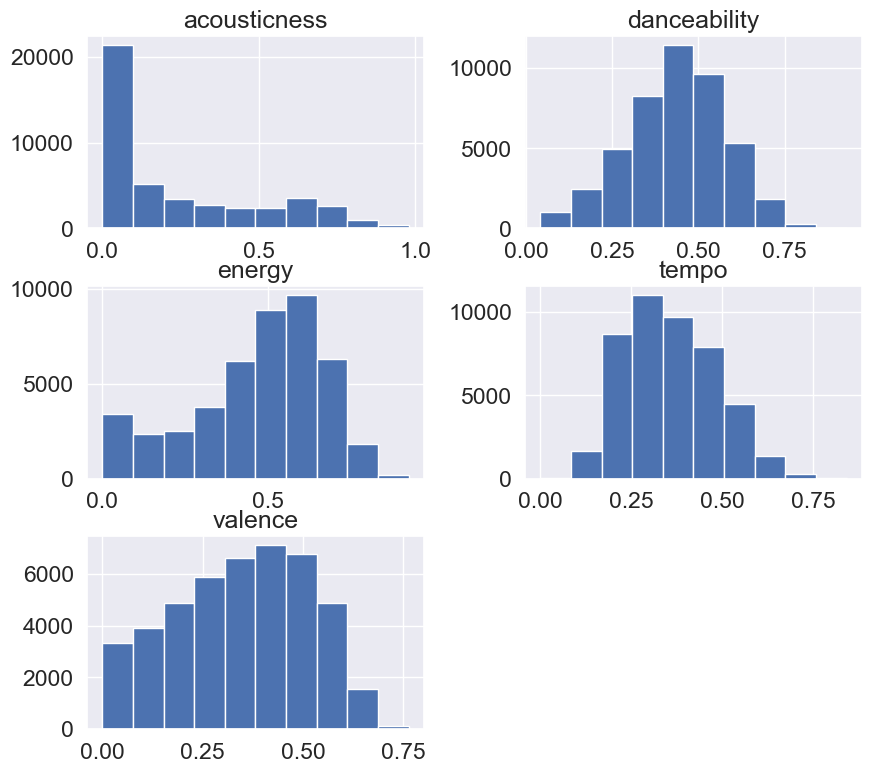

In [31]:
audio_cols = ['acousticness', 'danceability', 'energy', 'tempo', 'valence']
X_prenorm = tracks[audio_cols]
pd.DataFrame(X_prenorm,columns=audio_cols).hist(figsize=(10,9))

In [32]:
genre_count = tracks.groupby('music_genre').agg({'music_genre':'count'})['music_genre']
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values
print(genre_count)
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

music_genre
Alternative    4495
Anime          4497
Classical      4500
Electronic     4466
Jazz           8991
Rap            9024
Rock           9047
Name: music_genre, dtype: int64
Major genres: ['Alternative' 'Anime' 'Classical' 'Electronic' 'Jazz' 'Rap' 'Rock'] 
Minor Genres: []


### Balancing dataset

#### Shunfle the dataset

In [33]:
tracks

,artist_name,popularity,acousticness,danceability,energy,key,loudness,mode,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
0,Röyksopp,27.0,0.002869,0.399702,0.576871,A#,-5.201,Minor,0.219401,4-Apr,0.465298,Electronic,KM4,-0.058550,0.396077
1,Thievery Corporation,31.0,0.007925,0.388139,0.555376,D,-7.043,Minor,0.270696,4-Apr,0.331354,Electronic,KM4,0.032886,0.508352
2,Dillon Francis,28.0,0.002415,0.489314,0.595858,G#,-4.617,Major,0.397505,4-Apr,0.262809,Electronic,KM0,-0.278861,0.062953
3,Dubloadz,34.0,0.020752,0.632350,0.571893,C#,-4.498,Major,0.411582,4-Apr,0.220587,Electronic,KM9,-0.271294,0.018321
4,What So Not,32.0,0.003237,0.444191,0.408683,F#,-6.266,Major,0.414482,4-Apr,0.224880,Electronic,KM4,0.119279,0.526898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,BEXEY,59.0,0.027332,0.747124,0.469714,C#,-7.022,Major,0.280275,4-Apr,0.270045,Rap,KM9,-0.237992,-0.044341
50001,Roy Woods,72.0,0.164715,0.743841,0.379789,B,-9.814,Major,0.494842,4-Apr,0.118553,Rap,KM9,-0.077744,-0.087191
50002,Berner,51.0,0.004825,0.560089,0.616664,D,-5.443,Major,0.420482,4-Apr,0.319243,Rap,KM1,-0.311765,0.027483
50003,The-Dream,65.0,0.081896,0.770668,0.465160,G,-5.016,Minor,0.220176,4-Apr,0.348870,Rap,KM9,-0.207393,-0.089506


In [34]:
tracks.sample(frac=1)

,artist_name,popularity,acousticness,danceability,energy,key,loudness,mode,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
32017,Jeff Beck,51.0,0.127827,0.487339,0.260980,C,-13.181,Minor,0.386491,4-Apr,0.129602,Jazz,KM4,0.327799,0.507002
46266,empty_field,51.0,0.006683,0.366118,0.573437,A,-4.947,Major,0.484077,4-Apr,0.483011,Rap,KM8,-0.250340,0.107657
7793,Ayumi Hamasaki,27.0,0.715485,0.414188,0.258581,G#,-8.523,Major,0.314392,3-Apr,0.279939,Anime,KM6,0.388192,-0.362734
45951,Wiz Khalifa,65.0,0.132228,0.652084,0.465515,C#,-7.108,Major,0.529158,4-Apr,0.192002,Rap,KM9,-0.145382,-0.050124
43924,Wolfgang Amadeus Mozart,26.0,0.929140,0.167775,0.017268,F,-27.091,Major,0.309262,4-Apr,0.050038,Classical,KM6,0.787639,-0.370358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33618,Morphine,33.0,0.113679,0.433567,0.484679,C,-11.943,Major,0.430278,4-Apr,0.607170,Jazz,KM3,-0.182528,-0.042083
22658,Pistol Annies,42.0,0.006632,0.328384,0.574213,A#,-7.138,Major,0.614078,3-Apr,0.417359,Rock,KM8,-0.282846,0.045735
614,Armen Miran,37.0,0.001182,0.652460,0.352284,A#,-12.380,Minor,0.259163,4-Apr,0.055118,Electronic,KM4,0.156121,0.499001
30710,Allen Toussaint,29.0,0.141285,0.504988,0.437843,G,-9.710,Major,0.535204,4-Apr,0.473514,Jazz,KM3,-0.168049,-0.103543


In [35]:
tracks.sort_index()
tracks

,artist_name,popularity,acousticness,danceability,energy,key,loudness,mode,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
0,Röyksopp,27.0,0.002869,0.399702,0.576871,A#,-5.201,Minor,0.219401,4-Apr,0.465298,Electronic,KM4,-0.058550,0.396077
1,Thievery Corporation,31.0,0.007925,0.388139,0.555376,D,-7.043,Minor,0.270696,4-Apr,0.331354,Electronic,KM4,0.032886,0.508352
2,Dillon Francis,28.0,0.002415,0.489314,0.595858,G#,-4.617,Major,0.397505,4-Apr,0.262809,Electronic,KM0,-0.278861,0.062953
3,Dubloadz,34.0,0.020752,0.632350,0.571893,C#,-4.498,Major,0.411582,4-Apr,0.220587,Electronic,KM9,-0.271294,0.018321
4,What So Not,32.0,0.003237,0.444191,0.408683,F#,-6.266,Major,0.414482,4-Apr,0.224880,Electronic,KM4,0.119279,0.526898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,BEXEY,59.0,0.027332,0.747124,0.469714,C#,-7.022,Major,0.280275,4-Apr,0.270045,Rap,KM9,-0.237992,-0.044341
50001,Roy Woods,72.0,0.164715,0.743841,0.379789,B,-9.814,Major,0.494842,4-Apr,0.118553,Rap,KM9,-0.077744,-0.087191
50002,Berner,51.0,0.004825,0.560089,0.616664,D,-5.443,Major,0.420482,4-Apr,0.319243,Rap,KM1,-0.311765,0.027483
50003,The-Dream,65.0,0.081896,0.770668,0.465160,G,-5.016,Minor,0.220176,4-Apr,0.348870,Rap,KM9,-0.207393,-0.089506


#### Filtering rows

In [36]:
def reduce(genero):
    count = 0
    for i in range(len(tracks)):
        try:
            if tracks.iloc[i]['music_genre'] == genero and count < 5000:
                tracks.drop(tracks.index[i],inplace = True)
                count += 1
        except:
            continue

reduce("Jazz")            

In [37]:
reduce("Rap")

In [38]:
reduce("Rock")

In [39]:
tracks

,artist_name,popularity,acousticness,danceability,energy,key,loudness,mode,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
0,Röyksopp,27.0,0.002869,0.399702,0.576871,A#,-5.201,Minor,0.219401,4-Apr,0.465298,Electronic,KM4,-0.058550,0.396077
1,Thievery Corporation,31.0,0.007925,0.388139,0.555376,D,-7.043,Minor,0.270696,4-Apr,0.331354,Electronic,KM4,0.032886,0.508352
2,Dillon Francis,28.0,0.002415,0.489314,0.595858,G#,-4.617,Major,0.397505,4-Apr,0.262809,Electronic,KM0,-0.278861,0.062953
3,Dubloadz,34.0,0.020752,0.632350,0.571893,C#,-4.498,Major,0.411582,4-Apr,0.220587,Electronic,KM9,-0.271294,0.018321
4,What So Not,32.0,0.003237,0.444191,0.408683,F#,-6.266,Major,0.414482,4-Apr,0.224880,Electronic,KM4,0.119279,0.526898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,Unknown Mortal Orchestra,57.0,0.024711,0.564335,0.296123,C,-10.136,Major,0.254347,4-Apr,0.404361,Rap,KM4,0.125715,0.397735
49998,Logic,55.0,0.303738,0.329370,0.467783,E,-8.491,Minor,0.459442,4-Apr,0.447918,Rap,KM0,-0.043954,-0.143685
50000,BEXEY,59.0,0.027332,0.747124,0.469714,C#,-7.022,Major,0.280275,4-Apr,0.270045,Rap,KM9,-0.237992,-0.044341
50002,Berner,51.0,0.004825,0.560089,0.616664,D,-5.443,Major,0.420482,4-Apr,0.319243,Rap,KM1,-0.311765,0.027483


In [40]:
### method: Merge nearest genres
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values

# Scale Tempo
tempo = tracks['tempo'].values.reshape(-1,1)
tracks['tempo'] = MinMaxScaler().fit_transform(tempo)

# Normalize audio columns
norm = Normalizer()
tracks[audio_cols] = norm.fit_transform(tracks[audio_cols])

# Group By Mean
genre_groupby = tracks.groupby('music_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'music_genre':'cluster'}, axis=1)
#clusters['method'] = 'Mean'

minor_clusters = clusters.loc[clusters.cluster.isin(minor_genres)]
major_clusters =  clusters.loc[clusters.cluster.isin(major_genres)]

new_genres = dict(zip(major_genres,major_genres))

for i, r in minor_clusters.iterrows():
    genre = r[0]
    genre_coordinates = r[1:9].values
    genre_coordinates_other = major_clusters[audio_cols].values

    # Calculate distances between each genre; choose closest genre as the one with minimum distance
    distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
    min_distance = min(distances)
    closest_genre = major_genres[distances.index(min_distance)]
    print("minor genre: {}, closest major genre: {}".format(genre, closest_genre))

    # Reassign genre values for largely minority genres
    tracks['music_genre'].loc[tracks2['music_genre']==genre] = closest_genre
    new_genres[closest_genre] = new_genres[closest_genre] + "/" + genre

tracks = tracks.replace(new_genres)
print(tracks.groupby('music_genre').agg({'music_genre':'count'})['music_genre'])

music_genre
Alternative    4495
Anime          4497
Classical      4500
Electronic     4466
Jazz           4495
Rap            4512
Rock           4523
Name: music_genre, dtype: int64


In [41]:
genre_groupby = tracks.groupby('music_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'music_genre':'cluster'}, axis=1)
clusters['method'] = 'Mean'

clusters

,cluster,popularity,acousticness,danceability,energy,loudness,tempo,valence,x,y,method
0,Alternative,50.239822,0.139506,0.443593,0.574550,-6.545273,0.458971,0.352954,-0.162783,0.003982,Mean
1,Anime,24.279297,0.245004,0.372783,0.519658,-7.934473,0.468681,0.329775,0.019412,0.094835,Mean
2,Classical,29.255333,0.768493,0.262148,0.150237,-21.604702,0.384531,0.172039,0.674380,0.044684,Mean
3,Electronic,38.182938,0.102059,0.493466,0.582993,-7.070008,0.468408,0.297391,-0.078062,0.189768,Mean
4,Jazz,37.974416,0.326182,0.441571,0.426401,-10.136830,0.419686,0.417422,0.080972,-0.037414,Mean
5,Rap,59.408688,0.136464,0.559542,0.513640,-6.723701,0.438483,0.358807,-0.173984,-0.063464,Mean
6,Rock,52.968384,0.186911,0.447347,0.526098,-7.251287,0.454633,0.408242,-0.131893,-0.061919,Mean


array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>]],
      dtype=object)

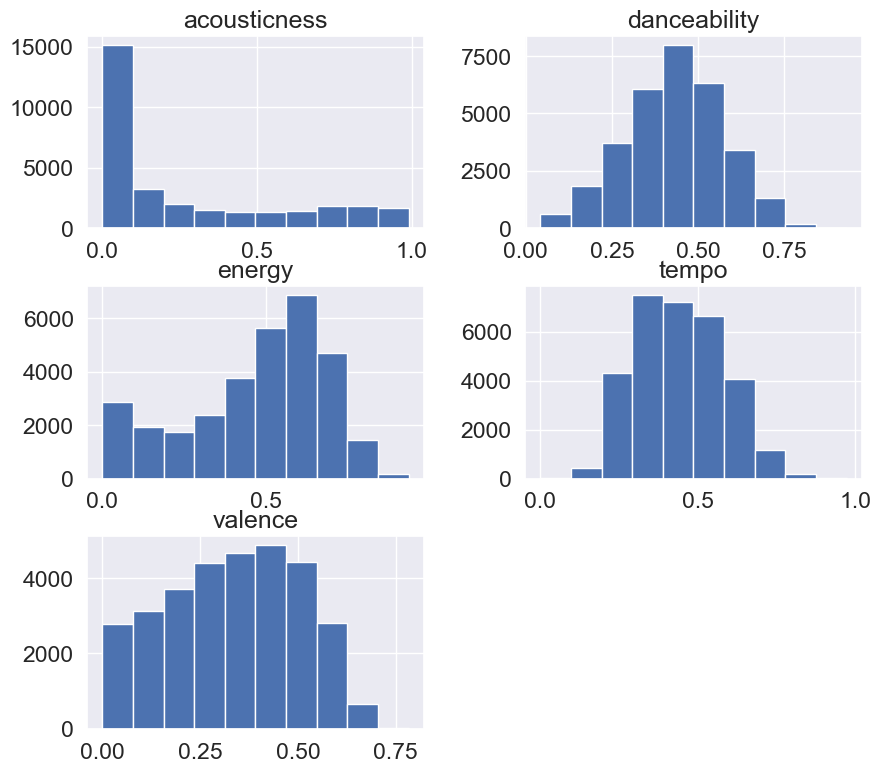

In [42]:
tracks[audio_cols].hist(figsize=(10,9))

In [43]:
clusters

,cluster,popularity,acousticness,danceability,energy,loudness,tempo,valence,x,y,method
0,Alternative,50.239822,0.139506,0.443593,0.574550,-6.545273,0.458971,0.352954,-0.162783,0.003982,Mean
1,Anime,24.279297,0.245004,0.372783,0.519658,-7.934473,0.468681,0.329775,0.019412,0.094835,Mean
2,Classical,29.255333,0.768493,0.262148,0.150237,-21.604702,0.384531,0.172039,0.674380,0.044684,Mean
3,Electronic,38.182938,0.102059,0.493466,0.582993,-7.070008,0.468408,0.297391,-0.078062,0.189768,Mean
4,Jazz,37.974416,0.326182,0.441571,0.426401,-10.136830,0.419686,0.417422,0.080972,-0.037414,Mean
5,Rap,59.408688,0.136464,0.559542,0.513640,-6.723701,0.438483,0.358807,-0.173984,-0.063464,Mean
6,Rock,52.968384,0.186911,0.447347,0.526098,-7.251287,0.454633,0.408242,-0.131893,-0.061919,Mean


In [44]:
X = tracks[['acousticness', 'danceability', 'energy', 'tempo', 'valence']]

km = KMeans(n_clusters=len(major_genres), n_init=10, random_state=1986)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
clusters = pd.concat([clusters, km_clusters])
cols = ['cluster'] + audio_cols + ['method']
clusters = clusters[cols]

In [45]:
clusters

,cluster,acousticness,danceability,energy,tempo,valence,method
0,Alternative,0.139506,0.443593,0.574550,0.458971,0.352954,Mean
1,Anime,0.245004,0.372783,0.519658,0.468681,0.329775,Mean
2,Classical,0.768493,0.262148,0.150237,0.384531,0.172039,Mean
3,Electronic,0.102059,0.493466,0.582993,0.468408,0.297391,Mean
4,Jazz,0.326182,0.441571,0.426401,0.419686,0.417422,Mean
5,Rap,0.136464,0.559542,0.513640,0.438483,0.358807,Mean
6,Rock,0.186911,0.447347,0.526098,0.454633,0.408242,Mean
0,KM0,0.653098,0.395041,0.240245,0.455043,0.285374,KMeans
1,KM1,0.055257,0.333381,0.598673,0.624397,0.307149,KMeans
2,KM2,0.865583,0.244253,0.092889,0.353572,0.110346,KMeans


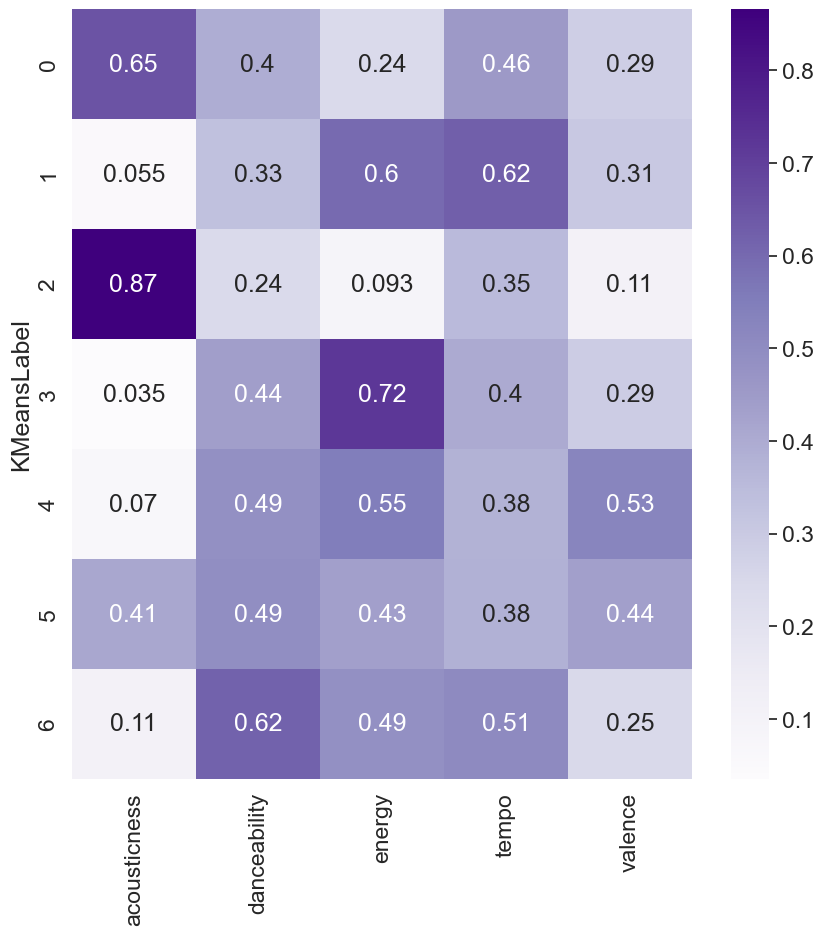

In [46]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(
    data=clusters.loc[clusters.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=True
)
plt.ylabel("KMeansLabel")
plt.savefig('heatmap_all.png')

* KM0: ?
* KM1: ?
* KM2: ?
* KM3: ?
* KM4: ? 
* KM5: ?
* KM6: ?

In [47]:

### Assign K-Means Label to Descriptive Labels
descriptive_labels = ["KM0", "KM1", "KM2", 
                     "KM3", "KM4", "KM5",
                     "KM6", "KM7", "KM8","KM9"]
unique_labels = np.unique(labels)
translated_labels = dict(zip(unique_labels, descriptive_labels))
tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], labels))

genre_count = tracks.groupby('music_genre').agg({'music_genre':'count'})['music_genre']

# How many instances of each k-means cluster are there?
print("### Instances of KMeans Cluster ###")
print(tracks[['music_genre', 'KMeansLabel']].groupby('KMeansLabel').agg('count'))

# Which cluster corresponds to the most instances per genre?
print("### Which cluster corresponds to the most instances per genre? ###")
print(tracks[['music_genre', 'KMeansLabel']].groupby('music_genre').agg(lambda x:x.value_counts().index[0]))

# Which genre corresponds to the most instances per cluster?
print("### Which genre corresponds to the most instances per cluster? ###")
print(tracks[['music_genre', 'KMeansLabel']].groupby('KMeansLabel').agg(lambda x:x.value_counts().index[0]))

### Instances of KMeans Cluster ###
             music_genre
KMeansLabel             
KM0                 3476
KM1                 4879
KM2                 4013
KM3                 4808
KM4                 7014
KM5                 3590
KM6                 3708
### Which cluster corresponds to the most instances per genre? ###
            KMeansLabel
music_genre            
Alternative         KM3
Anime               KM1
Classical           KM2
Electronic          KM3
Jazz                KM4
Rap                 KM6
Rock                KM4
### Which genre corresponds to the most instances per cluster? ###
            music_genre
KMeansLabel            
KM0           Classical
KM1               Anime
KM2           Classical
KM3          Electronic
KM4                Rock
KM5                Jazz
KM6                 Rap


In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
tracks['x'] = x
tracks['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [49]:
audio_components = dict(list(zip(audio_cols, zip(*np.round(components,2)))))
audio_components

{'acousticness': (0.81, -0.09),
 'danceability': (-0.16, -0.35),
 'energy': (-0.51, 0.17),
 'tempo': (-0.08, 0.56),
 'valence': (-0.21, -0.72)}

/Users/andrescarvajal/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Clustering by Genre, Reduced Dimension')

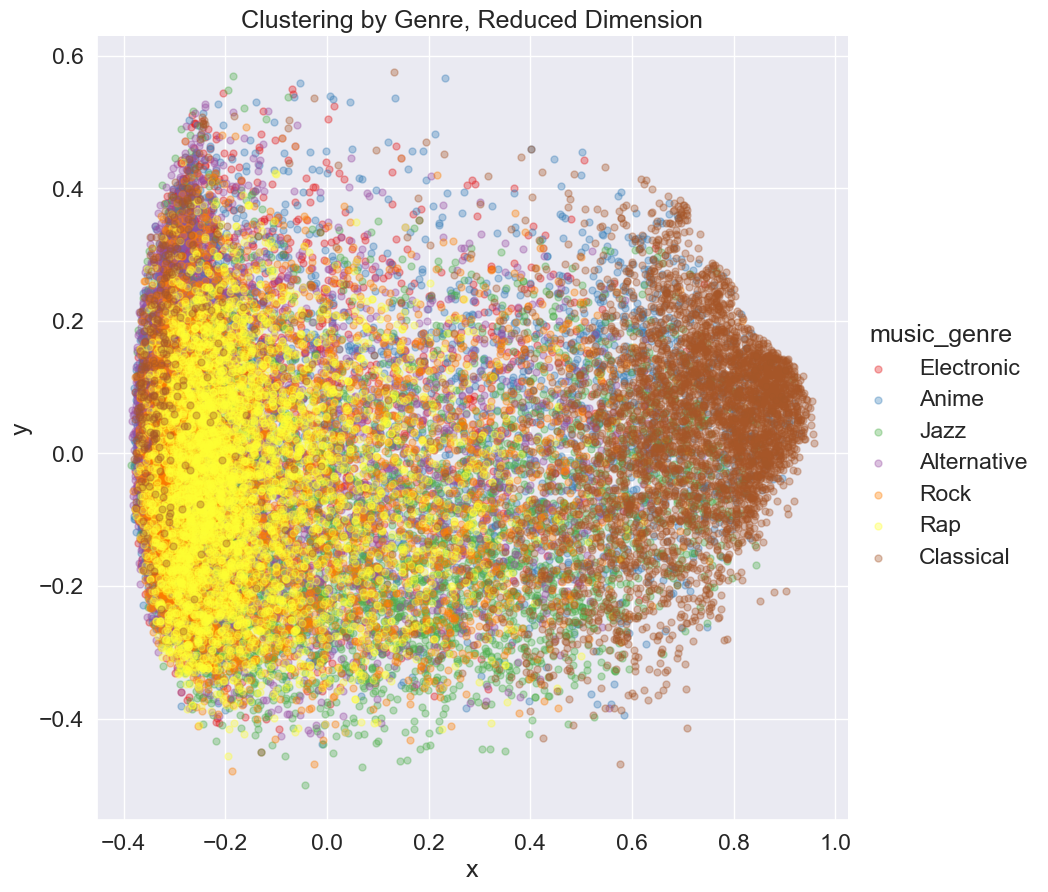

In [50]:
sns.set(font_scale=1.5)
sns.lmplot(data=tracks, x='x', y='y', hue='music_genre', fit_reg=False, legend=True, size=9, palette='Set1',scatter_kws={'alpha':0.35, 's':25})

plt.savefig('pca_scatter_genres.png')
plt.title("Clustering by Genre, Reduced Dimension")

/Users/andrescarvajal/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


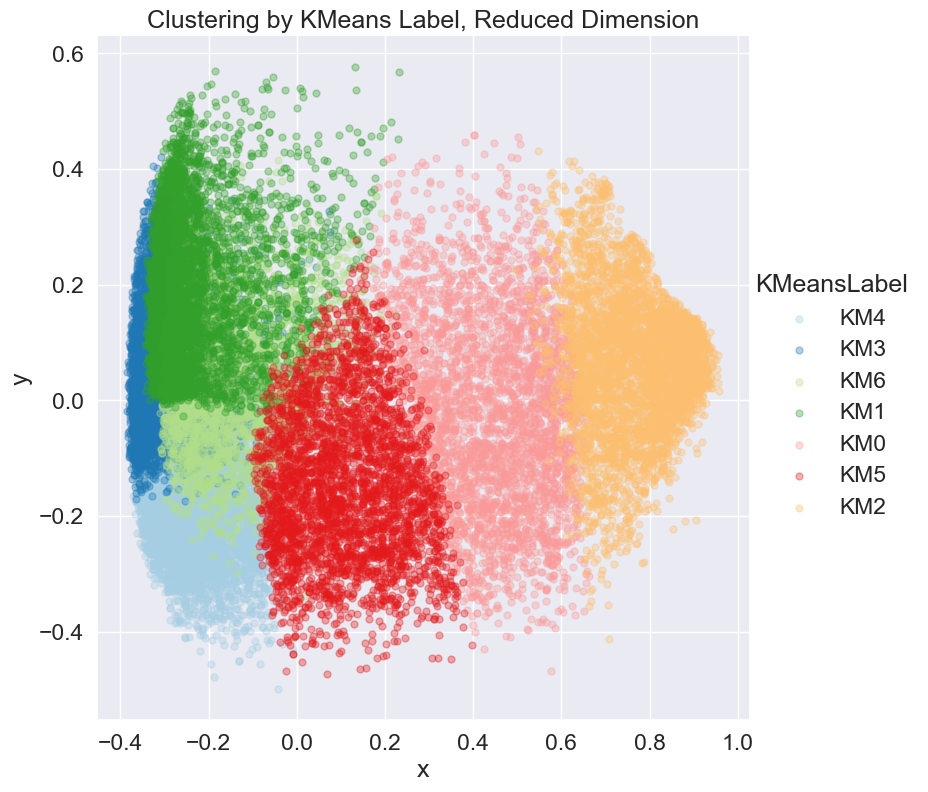

In [51]:
sns.set(font_scale=1.5)

sns.lmplot(data=tracks, x='x', y='y', hue='KMeansLabel', fit_reg=False, legend=True, size=8, palette='Paired',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")

plt.savefig('pca_scatter_KM.png')

In [52]:
tracks.head()

,artist_name,popularity,acousticness,danceability,energy,key,loudness,mode,tempo,obtained_date,valence,music_genre,KMeansLabel,x,y
0,Röyksopp,27.0,0.003251,0.452954,0.653726,A#,-5.201,Minor,0.299051,4-Apr,0.527288,Electronic,KM4,-0.344577,-0.172653
1,Thievery Corporation,31.0,0.009646,0.472441,0.676001,D,-7.043,Minor,0.396307,4-Apr,0.403322,Electronic,KM3,-0.336159,-0.031859
2,Dillon Francis,28.0,0.002557,0.518048,0.630849,G#,-4.617,Major,0.506192,4-Apr,0.278242,Electronic,KM3,-0.309135,0.097112
3,Dubloadz,34.0,0.020536,0.625786,0.565956,C#,-4.498,Major,0.489908,4-Apr,0.218297,Electronic,KM6,-0.264525,0.080685
4,What So Not,32.0,0.003975,0.545339,0.501746,F#,-6.266,Major,0.612059,4-Apr,0.276088,Electronic,KM6,-0.254446,0.125984
